In [3]:
import gymnasium as gym
from collections import defaultdict
import pickle
import time
#import gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import warnings
import os
warnings.simplefilter("ignore")


## Q-Learning Agent para MountainCar-v0

### Clase QLearningAgent

- __init__: inicializa el agente con hiperparámetros (epsilon, gamma, lr, etc.) y la tabla Q vacía.
- discretize_state: convierte el estado continuo (posición y velocidad) a valores discretos para indexar en la Q-table.
- choose_action: si el random < epsilon, explora; si no, escoge la mejor acción según la Q-table.
- update_q_table: actualiza el valor Q usando la fórmula de Q-learning con la recompensa y el próximo estado.
- save_model / load_model: guarda o carga la Q-table con pickle.

### train_agent

- Crea el entorno y el agente.
- Corre episodios, elige acciones, actualiza la Q-table con lo aprendido.
- Cada 500 episodios muestra promedio de recompensa, pasos y tasa de éxito.
- Va reduciendo epsilon para explorar menos con el tiempo.

### test_agent

- Prueba el agente entrenado con epsilon = 0 (solo explotación).
- Mide cuántas veces llega a la cima y cuántos pasos necesita.
- Si render = True, muestra la simulación visual.

### plot_training_progress

- Grafica recompensas y duración por episodio.
- También muestra un promedio móvil para ver si mejora con el tiempo.

### Bloque final

- Entrena el agente con 2000 episodios.
- Guarda el modelo en un archivo .pkl.
- Grafica el progreso.
- Lo prueba en 5 episodios sin render.


Starting training...
Training for 2000 episodes
Episode 0: Avg Reward: -200.00, Avg Length: 200.0, Success Rate: 0.0%, Epsilon: 0.367
Episode 500: Avg Reward: -200.00, Avg Length: 200.0, Success Rate: 0.0%, Epsilon: 0.010


c:\Users\Asus\anaconda3\envs\py312\Lib\site-packages\gymnasium\envs\classic_control\mountain_car.py:179: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


Episode 1000: Avg Reward: -194.30, Avg Length: 194.3, Success Rate: 6.5%, Epsilon: 0.010
Episode 1500: Avg Reward: -171.78, Avg Length: 171.8, Success Rate: 13.4%, Epsilon: 0.010

Training completed!
Final success rate: 21.4%


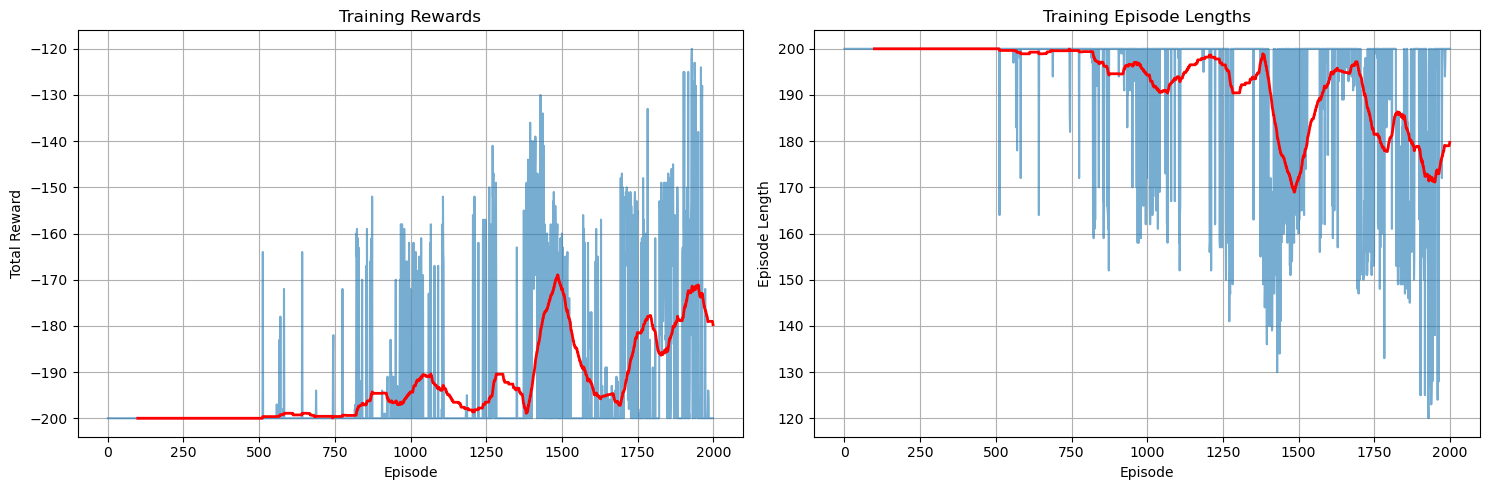

Model saved as 'mountain_car_q_agent.pkl'

Testing agent for 5 episodes...
Episode 1: Failed in 200 steps. Reward: -200.0
Episode 2: Failed in 200 steps. Reward: -200.0
Episode 3: Failed in 200 steps. Reward: -200.0
Episode 4: Failed in 200 steps. Reward: -200.0
Episode 5: SUCCESS in 163 steps! Reward: -163.0

Test Results:
Success Rate: 20.0%
Average Steps: 192.6
Average Reward: -192.60

To test with visual rendering, run:

Testing agent for 3 episodes...
Episode 1: Failed in 200 steps. Reward: -200.0
Episode 2: Failed in 200 steps. Reward: -200.0
Episode 3: Failed in 200 steps. Reward: -200.0

Test Results:
Success Rate: 0.0%
Average Steps: 200.0
Average Reward: -200.00
([-200.0, -200.0, -200.0], [200, 200, 200])


In [ ]:

class QLearningAgent:
    def __init__(self, n_actions, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):

        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
        
    def discretize_state(self, state, n_bins=20):
    
        position, velocity = state
        
        pos_bins = np.linspace(-1.2, 0.6, n_bins)
        vel_bins = np.linspace(-0.07, 0.07, n_bins)

        pos_idx = np.digitize(position, pos_bins)
        vel_idx = np.digitize(velocity, vel_bins)

        pos_idx = np.clip(pos_idx, 0, n_bins - 1)
        vel_idx = np.clip(vel_idx, 0, n_bins - 1)
        
        return (pos_idx, vel_idx)
    
    def choose_action(self, state):
    
        discrete_state = self.discretize_state(state)
        
        if np.random.random() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            q_values = self.q_table[discrete_state]
            return np.argmax(q_values)
    
    def update_q_table(self, state, action, reward, next_state, done):
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        current_q = self.q_table[discrete_state][action]
        
        if done:
            target_q = reward
        else:
            next_q_values = self.q_table[discrete_next_state]
            target_q = reward + self.gamma * np.max(next_q_values)
        
        self.q_table[discrete_state][action] += self.lr * (target_q - current_q)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)
    
    def load_model(self, filename):
        with open(filename, 'rb') as f:
            q_dict = pickle.load(f)
            self.q_table = defaultdict(lambda: np.zeros(self.n_actions), q_dict)

def train_agent(n_episodes=5000, render_every=1000):
    env = gym.make('MountainCar-v0')
    agent = QLearningAgent(
        n_actions=env.action_space.n,
        learning_rate=0.1,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01
    )
    
    episode_rewards = []
    episode_lengths = []
    success_count = 0
    
    print("Starting training...")
    print(f"Training for {n_episodes} episodes")
    
    for episode in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  
            
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action = agent.choose_action(state)
            result = env.step(action)
            
            if len(result) == 4:
                next_state, reward, done, _ = result
            else:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            
            agent.update_q_table(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            steps += 1
            
            if episode % render_every == 0 and episode > 0:
                env.render()
        
        if state[0] >= 0.5: 
            success_count += 1
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        if episode % 500 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if episode_rewards else 0
            avg_length = np.mean(episode_lengths[-100:]) if episode_lengths else 0
            success_rate = success_count / (episode + 1) * 100
            print(f"Episode {episode}: Avg Reward: {avg_reward:.2f}, "
                  f"Avg Length: {avg_length:.1f}, Success Rate: {success_rate:.1f}%, "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    env.close()
    
    print(f"\nTraining completed!")
    print(f"Final success rate: {success_count/n_episodes*100:.1f}%")
    
    return agent, episode_rewards, episode_lengths

def test_agent(agent, n_episodes=10, render=True):
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    test_rewards = []
    test_lengths = []
    successes = 0
    
    print(f"\nTesting agent for {n_episodes} episodes...")
    
    for episode in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
            
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action = agent.choose_action(state)
            result = env.step(action)
            
            if len(result) == 4:
                next_state, reward, done, _ = result
            else:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            
            state = next_state
            total_reward += reward
            steps += 1
            
            if render:
                env.render()
        
        if state[0] >= 0.5:
            successes += 1
            print(f"Episode {episode + 1}: SUCCESS in {steps} steps! Reward: {total_reward}")
        else:
            print(f"Episode {episode + 1}: Failed in {steps} steps. Reward: {total_reward}")
        
        test_rewards.append(total_reward)
        test_lengths.append(steps)
    
    env.close()
    
    agent.epsilon = original_epsilon
    
    print(f"\nTest Results:")
    print(f"Success Rate: {successes/n_episodes*100:.1f}%")
    print(f"Average Steps: {np.mean(test_lengths):.1f}")
    print(f"Average Reward: {np.mean(test_rewards):.2f}")
    
    return test_rewards, test_lengths

def plot_training_progress(episode_rewards, episode_lengths):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(episode_rewards, alpha=0.6)
    window = 100
    if len(episode_rewards) >= window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episode_rewards)), moving_avg, 'r-', linewidth=2)
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Rewards')
    ax1.grid(True)
    ax2.plot(episode_lengths, alpha=0.6)
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(episode_lengths)), moving_avg, 'r-', linewidth=2)
    
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Episode Length')
    ax2.set_title('Training Episode Lengths')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    agent, rewards, lengths = train_agent(n_episodes=2000)
    
    plot_training_progress(rewards, lengths)
    
    agent.save_model('mountain_car_q_agent.pkl')
    print("Model saved as 'mountain_car_q_agent.pkl'")
    
    test_rewards, test_lengths = test_agent(agent, n_episodes=5, render=False)
    
    print("\nTo test with visual rendering, run:")
    print(test_agent(agent, n_episodes=3, render=True))

## DQN MountainCar

### Modelo DQN

Se crea una red neuronal simple:
- Entrada: estado del carro (posición y velocidad).
- Salida: valor Q para cada acción (izquierda, nada, derecha).
- Arquitectura: 2 capas ocultas con ReLU.


In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

### Funciones auxiliares

- normalize_state: normaliza el estado continuo (posición, velocidad) para que esté entre 0 y 1.
- select_action: aplica la política e-greedy. A veces toma acción random (explora), a veces escoge la mejor según la red.


In [ ]:
def normalize_state(state):
    low = np.array([-1.2, -0.07])
    high = np.array([0.6, 0.07])
    return (state - low) / (high - low)

def select_action(model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state)
            q_values = model(state_tensor)
            return torch.argmax(q_values).item()

### Entrenamiento

- Se inicializa el entorno y la red.
- Se usa memoria de experiencia para guardar las transiciones.
- Se entrena por episodios:
  - Ejecuta acciones, guarda experiencias.
  - Cuando hay suficientes datos, se entrena con minibatches.
  - Se actualiza el modelo objetivo (target_model) cada episodio.
  - Se reduce epsilon para explorar menos con el tiempo.
- Cada 50 episodios se imprime el rendimiento promedio.


In [ ]:
env = gym.make('MountainCar-v0')
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

model = DQN(input_dim=state_dim, output_dim=n_actions)
target_model = DQN(input_dim=state_dim, output_dim=n_actions)
target_model.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

episodes = 500
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
memory = deque(maxlen=10000)
rewards = []

for ep in range(episodes):
    state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
    state = normalize_state(state)
    total_reward = 0
    done = False

    while not done:
        action = select_action(model, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state_norm = normalize_state(next_state)
        memory.append((state, action, reward, next_state_norm, done))
        state = next_state_norm
        total_reward += reward

        if len(memory) >= batch_size:
            minibatch = random.sample(memory, batch_size)
            states, actions, rewards_batch, next_states, dones = zip(*minibatch)

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            rewards_batch = torch.FloatTensor(rewards_batch)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)

            q_values = model(states)
            next_q_values = target_model(next_states)

            q_target = q_values.clone()
            for i in range(batch_size):
                q_target[i, actions[i]] = rewards_batch[i] + gamma * torch.max(next_q_values[i]) * (1 - dones[i])

            loss = criterion(q_values, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    target_model.load_state_dict(model.state_dict())

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards.append(total_reward)

    if (ep + 1) % 50 == 0:
        avg_reward = np.mean(rewards[-50:])
        print(f"Episode {ep + 1}, Avg Reward (last 50): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

### Prueba del agente y grabación en video

- Se prueba el agente ya entrenado, sin exploración (epsilon = 0).
- Se graba el episodio completo en un video.
- Se guarda el video en una carpeta (mountaincar_videos).


In [ ]:
video_folder = "./mountaincar_videos"
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)
state = normalize_state(env.reset()[0])
done = False
total_reward = 0

while not done:
    action = select_action(model, state, epsilon=0.0)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = normalize_state(next_state)
    state = next_state
    total_reward += reward

env.close()
print(f"Recompensa total del episodio grabado: {total_reward}")

### Gráfica de recompensas

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodio')
plt.ylabel('Recompensa total')
plt.title('Progreso del entrenamiento')
plt.grid(True)
plt.show()

## Q-Learning Agent para CartPole-v1

### Clase QLearningAgent

- __init__: inicializa los hiperparámetros (número de bins, tasa de aprendizaje, descuento, epsilon, etc.) y la tabla Q como un `defaultdict` con dos acciones posibles (izquierda/derecha).
- discretize_state: convierte el estado continuo (posición, velocidad, ángulo y velocidad angular) a una versión discreta que permite indexar la Q-table.
- choose_action: usa una política ε-greedy. Si `random < epsilon`, elige una acción aleatoria (exploración); si no, toma la acción con mayor valor Q (explotación).
- update_q_table: aplica la fórmula de Q-learning para actualizar la tabla con base en la recompensa y el estado siguiente.
- decay_epsilon: reduce epsilon de forma progresiva para que el agente explore menos con el tiempo.
- save_model / load_model: guarda o carga la Q-table desde un archivo `.pkl` usando `pickle`.

### train_agent

- Crea el entorno de `CartPole-v1` y una instancia del agente.
- Por cada episodio:
  - Resetea el entorno y toma acciones hasta que termine el episodio.
  - Actualiza la Q-table en cada paso.
  - Registra la recompensa total y decae `epsilon`.
- Muestra cada 100 episodios el promedio de recompensas y el valor actual de epsilon.

### test_agent

- Ejecuta el agente ya entrenado sin exploración (`epsilon = 0`).
- Mide cuántas recompensas consigue en cada episodio.
- Si `render = True`, muestra visualmente el comportamiento del agente en el entorno.

### plot_training_progress

- Grafica las recompensas por episodio.
- Muestra una media móvil de 100 episodios para ver si el aprendizaje es efectivo.
- También grafica cómo decae el valor de epsilon durante el entrenamiento.

### analyze_q_table

- Imprime cuántos estados únicos se visitaron.
- Muestra el valor Q máximo aprendido y el promedio.
- Analiza qué tanta preferencia tiene el agente por cada acción (izquierda o derecha).

### Bloque final

- Entrena el agente durante 1000 episodios.
- Grafica el progreso de entrenamiento.
- Analiza la Q-table aprendida.
- Prueba el agente durante 5 episodios sin renderizado.
- Guarda el modelo como `'cartpole_qlearning_model.pkl'`.


Starting Q-Learning training...
Episode 0, Avg Reward: 13.00, Epsilon: 0.995


c:\Users\Asus\anaconda3\envs\py312\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Episode 100, Avg Reward: 24.51, Epsilon: 0.603
Episode 200, Avg Reward: 29.71, Epsilon: 0.365
Episode 300, Avg Reward: 43.21, Epsilon: 0.221
Episode 400, Avg Reward: 58.03, Epsilon: 0.134
Episode 500, Avg Reward: 58.50, Epsilon: 0.081
Episode 600, Avg Reward: 60.44, Epsilon: 0.049
Episode 700, Avg Reward: 65.18, Epsilon: 0.030
Episode 800, Avg Reward: 67.54, Epsilon: 0.018
Episode 900, Avg Reward: 69.96, Epsilon: 0.011


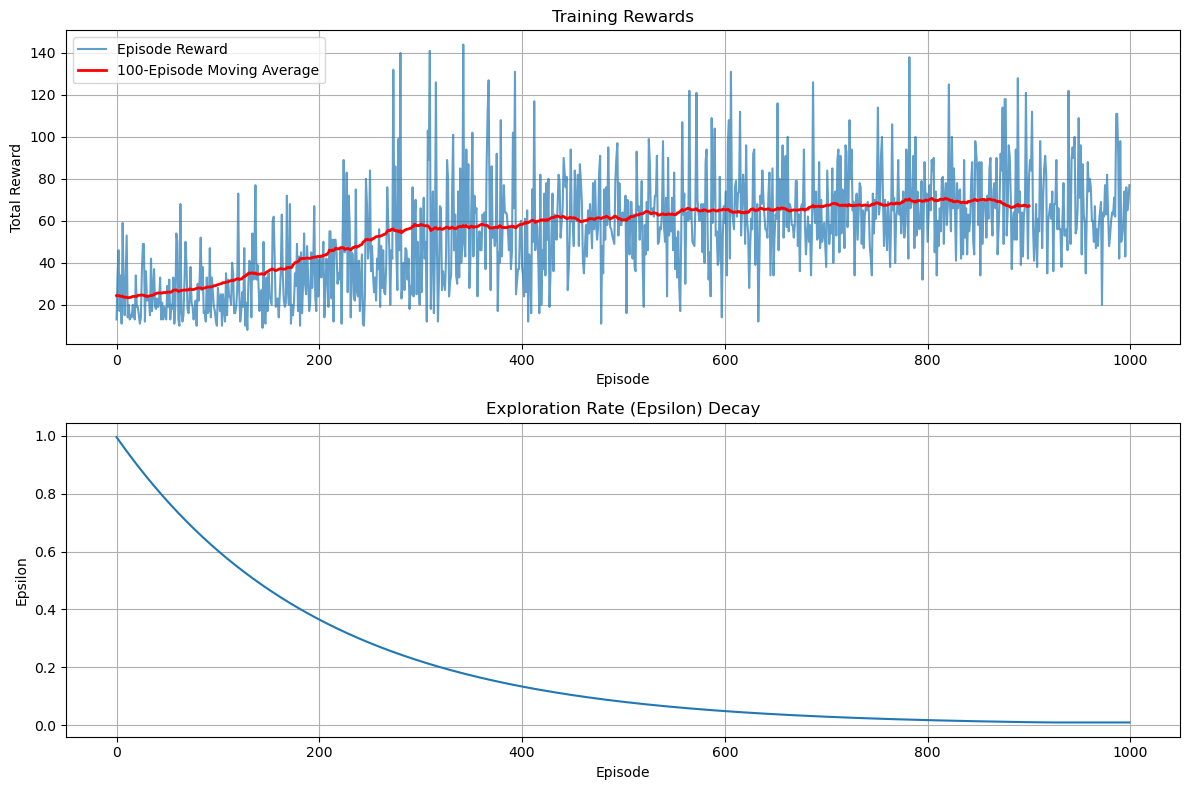


Q-table Analysis:
Number of states visited: 1489
Maximum Q-value: 17.983
Average maximum Q-value: 1.095
States preferring action 0 (left): 1070 (71.9%)
States preferring action 1 (right): 419 (28.1%)

Testing trained agent...
Test Episode 1: Reward = 51.0
Test Episode 2: Reward = 48.0
Test Episode 3: Reward = 62.0
Test Episode 4: Reward = 52.0
Test Episode 5: Reward = 75.0

Average test reward: 57.60

Model saved as 'cartpole_qlearning_model.pkl'


In [ ]:
class QLearningAgent:
    def __init__(self, n_bins=20, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Q-Learning Agent for CartPole environment
        
        Args:
            n_bins: Number of bins for discretizing continuous state space
            learning_rate: Learning rate (alpha)
            discount_factor: Discount factor (gamma)
            epsilon: Initial exploration rate
            epsilon_decay: Decay rate for epsilon
            epsilon_min: Minimum epsilon value
        """
        self.n_bins = n_bins
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.q_table = defaultdict(lambda: np.zeros(2))  
        
        self.state_bounds = [
            [-2.4, 2.4],      
            [-2.0, 2.0],      
            [-0.2095, 0.2095], 
            [-2.0, 2.0]       
        ]
        
    def discretize_state(self, state):
        """Convert continuous state to discrete state"""
        discrete_state = []
        for i, val in enumerate(state):
            val = np.clip(val, self.state_bounds[i][0], self.state_bounds[i][1])
            normalized = (val - self.state_bounds[i][0]) / (self.state_bounds[i][1] - self.state_bounds[i][0])
            bin_idx = int(normalized * (self.n_bins - 1))
            discrete_state.append(bin_idx)
        return tuple(discrete_state)
    
    def choose_action(self, state, training=True):
        """Choose action using epsilon-greedy policy"""
        discrete_state = self.discretize_state(state)
        
        if training and np.random.random() < self.epsilon:
            return np.random.randint(2)
        else:
            return np.argmax(self.q_table[discrete_state])
    
    def update_q_table(self, state, action, reward, next_state, done):
        """Update Q-table using Q-learning update rule"""
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        
        current_q = self.q_table[discrete_state][action]
        
        if done:
            next_q = 0
        else:
            next_q = np.max(self.q_table[discrete_next_state])
        
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * next_q - current_q)
        self.q_table[discrete_state][action] = new_q
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def save_model(self, filename):
        """Save the Q-table to file"""
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)
    
    def load_model(self, filename):
        """Load Q-table from file"""
        with open(filename, 'rb') as f:
            q_dict = pickle.load(f)
            self.q_table = defaultdict(lambda: np.zeros(2), q_dict)

def train_agent(episodes=1000, render_every=100):
    """Train the Q-Learning agent"""
    env = gym.make('CartPole-v1')
    agent = QLearningAgent()
    
    rewards = []
    epsilons = []
    
    print("Starting Q-Learning training...")
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  
        
        total_reward = 0
        done = False
        
        while not done:
            if episode % render_every == 0 and episode > 0:
                env.render()
            
            action = agent.choose_action(state, training=True)
            next_state, reward, done, truncated, info = env.step(action)
            
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            done = done or truncated
            
            agent.update_q_table(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
        
        agent.decay_epsilon()
        
        rewards.append(total_reward)
        epsilons.append(agent.epsilon)
        
        if episode % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    
    env.close()
    return agent, rewards, epsilons

def test_agent(agent, episodes=10, render=True):
    """Test the trained agent"""
    env = gym.make('CartPole-v1', render_mode='human' if render else None)
    
    test_rewards = []
    
    print("\nTesting trained agent...")
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        total_reward = 0
        done = False
        
        while not done:
            if render:
                env.render()
            
            action = agent.choose_action(state, training=False)
            next_state, reward, done, truncated, info = env.step(action)
            
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            done = done or truncated
            
            state = next_state
            total_reward += reward
        
        test_rewards.append(total_reward)
        print(f"Test Episode {episode + 1}: Reward = {total_reward}")
    
    env.close()
    avg_test_reward = np.mean(test_rewards)
    print(f"\nAverage test reward: {avg_test_reward:.2f}")
    return test_rewards

def plot_training_progress(rewards, epsilons):
    """Plot training metrics"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(rewards, alpha=0.7)
    ax1.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'), 'r-', linewidth=2)
    ax1.set_title('Training Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.legend(['Episode Reward', '100-Episode Moving Average'])
    ax1.grid(True)
    
    ax2.plot(epsilons)
    ax2.set_title('Exploration Rate (Epsilon) Decay')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Epsilon')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_q_table(agent):
    """Analyze the learned Q-table"""
    print(f"\nQ-table Analysis:")
    print(f"Number of states visited: {len(agent.q_table)}")
    
    max_q_values = []
    for state, q_values in agent.q_table.items():
        max_q_values.append(np.max(q_values))
    
    print(f"Maximum Q-value: {np.max(max_q_values):.3f}")
    print(f"Average maximum Q-value: {np.mean(max_q_values):.3f}")
    
    action_preferences = []
    for state, q_values in agent.q_table.items():
        action_preferences.append(np.argmax(q_values))
    
    action_0_count = action_preferences.count(0)
    action_1_count = action_preferences.count(1)
    total_states = len(action_preferences)
    
    print(f"States preferring action 0 (left): {action_0_count} ({action_0_count/total_states*100:.1f}%)")
    print(f"States preferring action 1 (right): {action_1_count} ({action_1_count/total_states*100:.1f}%)")

if __name__ == "__main__":
    trained_agent, training_rewards, training_epsilons = train_agent(episodes=1000)
    
    plot_training_progress(training_rewards, training_epsilons)
    
    analyze_q_table(trained_agent)
    
    test_rewards = test_agent(trained_agent, episodes=5, render=False)
    
    trained_agent.save_model('cartpole_qlearning_model.pkl')
    print("\nModel saved as 'cartpole_qlearning_model.pkl'")
    
    # Carga del modelo (opcional)
    # new_agent = QLearningAgent()
    # new_agent.load_model('cartpole_qlearning_model.pkl')
    # test_agent(new_agent, episodes=3, render=False)

## DQN CartPole

### Definición del modelo de red neuronal
Creamos una red neuronal simple con dos capas ocultas que toma como entrada el estado y predice los Q-valores para cada acción.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.output = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

### Parámetros y configuración inicial
Definimos el entorno, los tamaños, la memoria de replay y los hiperparámetros de entrenamiento.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random

In [35]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

Using device: cpu


In [36]:
class DQNNetwork(nn.Module):
    """Deep Q-Network architecture"""
    
    def __init__(self, state_size=4, action_size=2, hidden_size=128):
        super(DQNNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, action_size)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """Initialize network weights"""
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)
    
    def forward(self, x):
        """Forward pass through the network"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [37]:
class ReplayBuffer:
    """Experience Replay Buffer"""
    
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """Sample a batch of experiences"""
        experiences = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor([e.state for e in experiences]).to(device)
        actions = torch.LongTensor([e.action for e in experiences]).to(device)
        rewards = torch.FloatTensor([e.reward for e in experiences]).to(device)
        next_states = torch.FloatTensor([e.next_state for e in experiences]).to(device)
        dones = torch.BoolTensor([e.done for e in experiences]).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

In [38]:
class DQNAgent:
    """Deep Q-Network Agent"""
    
    def __init__(self, state_size=4, action_size=2, learning_rate=0.001,
                 gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 buffer_size=10000, batch_size=64, target_update_freq=100):
        """
        Initialize DQN Agent
        
        Args:
            state_size: Dimension of state space
            action_size: Dimension of action space
            learning_rate: Learning rate for optimizer
            gamma: Discount factor
            epsilon: Initial exploration rate
            epsilon_decay: Decay rate for epsilon
            epsilon_min: Minimum epsilon value
            buffer_size: Size of replay buffer
            batch_size: Batch size for training
            target_update_freq: Frequency to update target network
        """
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_counter = 0
        
        # Neural networks
        self.q_network = DQNNetwork(state_size, action_size).to(device)
        self.target_network = DQNNetwork(state_size, action_size).to(device)
        
        # Initialize target network with same weights
        self.update_target_network()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)
        
        # Training metrics
        self.losses = []
    
    def choose_action(self, state, training=True):
        """Choose action using epsilon-greedy policy"""
        if training and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_network(state_tensor)
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.push(state, action, reward, next_state, done)
    
    def replay(self):
        """Train the network on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Next Q values from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        
        self.optimizer.step()
        
        # Store loss for plotting
        self.losses.append(loss.item())
        
        # Update target network
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.update_target_network()
    
    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def save_model(self, filepath):
        """Save the trained model"""
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a trained model"""
        checkpoint = torch.load(filepath, map_location=device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        print(f"Model loaded from {filepath}")

In [39]:
def train_dqn(episodes=1000, max_steps_per_episode=500, render_every=100):
    """Train the DQN agent"""
    env = gym.make('CartPole-v1')
    agent = DQNAgent()
    
    # Training metrics
    rewards = []
    epsilons = []
    avg_losses = []
    
    print("Starting DQN training...")
    print(f"Network architecture: {agent.q_network}")
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  # Handle new gym API
        
        total_reward = 0
        steps = 0
        
        for step in range(max_steps_per_episode):
            # Render occasionally
            if episode % render_every == 0 and episode > 0:
                env.render()
            
            # Choose and take action
            action = agent.choose_action(state, training=True)
            next_state, reward, done, truncated, info = env.step(action)
            
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            done = done or truncated
            
            # Store experience
            agent.remember(state, action, reward, next_state, done)
            
            # Train the agent
            agent.replay()
            
            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        # Decay exploration rate
        agent.decay_epsilon()
        
        # Store metrics
        rewards.append(total_reward)
        epsilons.append(agent.epsilon)
        
        # Average loss over recent training steps
        recent_losses = agent.losses[-100:] if agent.losses else [0]
        avg_losses.append(np.mean(recent_losses))
        
        # Print progress
        if episode % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            avg_loss = np.mean(recent_losses)
            print(f"Episode {episode:4d} | Avg Reward: {avg_reward:6.2f} | "
                  f"Epsilon: {agent.epsilon:.3f} | Avg Loss: {avg_loss:.4f} | "
                  f"Buffer Size: {len(agent.memory)}")
    
    env.close()
    return agent, rewards, epsilons, avg_losses

In [41]:

def test_dqn(agent, episodes=10, render=True, max_steps=500):
    """Test the trained DQN agent"""
    env = gym.make('CartPole-v1', render_mode='human' if render else None)
    
    test_rewards = []
    
    print("\nTesting trained DQN agent...")
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        total_reward = 0
        
        for step in range(max_steps):
            if render:
                env.render()
            
            # Use trained policy (no exploration)
            action = agent.choose_action(state, training=False)
            next_state, reward, done, truncated, info = env.step(action)
            
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            done = done or truncated
            
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        test_rewards.append(total_reward)
        print(f"Test Episode {episode + 1:2d}: Reward = {total_reward:3.0f}, Steps = {step + 1}")
    
    env.close()
    avg_test_reward = np.mean(test_rewards)
    print(f"\nAverage test reward: {avg_test_reward:.2f}")
    print(f"Success rate (≥195 steps): {sum(r >= 195 for r in test_rewards)/len(test_rewards)*100:.1f}%")
    return test_rewards

In [42]:
def plot_training_progress(rewards, epsilons, losses):
    """Plot comprehensive training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Rewards plot
    axes[0, 0].plot(rewards, alpha=0.6, color='blue', linewidth=0.8)
    if len(rewards) >= 100:
        moving_avg = np.convolve(rewards, np.ones(100)/100, mode='valid')
        axes[0, 0].plot(range(99, len(rewards)), moving_avg, 'r-', linewidth=2, label='100-episode MA')
        axes[0, 0].legend()
    axes[0, 0].set_title('Training Rewards')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=195, color='green', linestyle='--', alpha=0.7, label='Solved threshold')
    
    # Epsilon decay
    axes[0, 1].plot(epsilons, color='orange')
    axes[0, 1].set_title('Exploration Rate (Epsilon)')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Epsilon')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1, 0].plot(losses, alpha=0.7, color='red')
    if len(losses) >= 50:
        loss_ma = np.convolve(losses, np.ones(50)/50, mode='valid')
        axes[1, 0].plot(range(49, len(losses)), loss_ma, 'darkred', linewidth=2)
    axes[1, 0].set_title('Training Loss')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Average Loss')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')
    
    # Performance histogram
    recent_rewards = rewards[-200:] if len(rewards) >= 200 else rewards
    axes[1, 1].hist(recent_rewards, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(x=195, color='green', linestyle='--', linewidth=2, label='Solved threshold')
    axes[1, 1].set_title('Recent Performance Distribution')
    axes[1, 1].set_xlabel('Episode Reward')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [43]:
def analyze_network(agent):
    """Analyze the trained network"""
    print(f"\nDQN Network Analysis:")
    print(f"Network parameters: {sum(p.numel() for p in agent.q_network.parameters())}")
    print(f"Replay buffer size: {len(agent.memory)}")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    
    # Sample some Q-values for different states
    print(f"\nSample Q-values for different states:")
    sample_states = [
        [0.0, 0.0, 0.0, 0.0],      # Balanced
        [1.0, 0.0, 0.1, 0.0],      # Cart right, pole tilted
        [-1.0, 0.0, -0.1, 0.0],    # Cart left, pole tilted opposite
        [0.0, 1.0, 0.0, 1.0],      # Moving right
        [0.0, -1.0, 0.0, -1.0],    # Moving left
    ]
    
    state_descriptions = [
        "Balanced state",
        "Cart right, pole right",
        "Cart left, pole left", 
        "Moving right",
        "Moving left"
    ]
    
    agent.q_network.eval()
    with torch.no_grad():
        for state, desc in zip(sample_states, state_descriptions):
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = agent.q_network(state_tensor).cpu().numpy()[0]
            action = np.argmax(q_values)
            print(f"{desc:20}: Q=[{q_values[0]:6.3f}, {q_values[1]:6.3f}] -> Action {action}")


DEEP Q-NETWORK (DQN) TRAINING
Starting DQN training...
Network architecture: DQNNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)
Episode    0 | Avg Reward:   8.00 | Epsilon: 0.995 | Avg Loss: 0.0000 | Buffer Size: 8
Episode  100 | Avg Reward:  32.58 | Epsilon: 0.603 | Avg Loss: 2.1816 | Buffer Size: 3266
Episode  200 | Avg Reward:  51.73 | Epsilon: 0.365 | Avg Loss: 11.6257 | Buffer Size: 8439
Episode  300 | Avg Reward:  62.41 | Epsilon: 0.221 | Avg Loss: 19.8946 | Buffer Size: 10000
Episode  400 | Avg Reward: 172.16 | Epsilon: 0.134 | Avg Loss: 45.4828 | Buffer Size: 10000
Episode  500 | Avg Reward: 262.04 | Epsilon: 0.081 | Avg Loss: 48.8120 | Buffer Size: 10000
Episode  600 | Avg Reward: 157.77 | Epsilon: 0.049 | Avg Loss: 32.4128 | Buffer Size: 10000
Episode  700 | Avg Reward: 30

Exception ignored in: <function RecordVideo.__del__ at 0x00000151CFC72CA0>
Traceback (most recent call last):
  File "c:\Users\Asus\anaconda3\envs\py312\Lib\site-packages\gymnasium\wrappers\rendering.py", line 415, in __del__
    if len(self.recorded_frames) > 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'RecordVideo' object has no attribute 'recorded_frames'


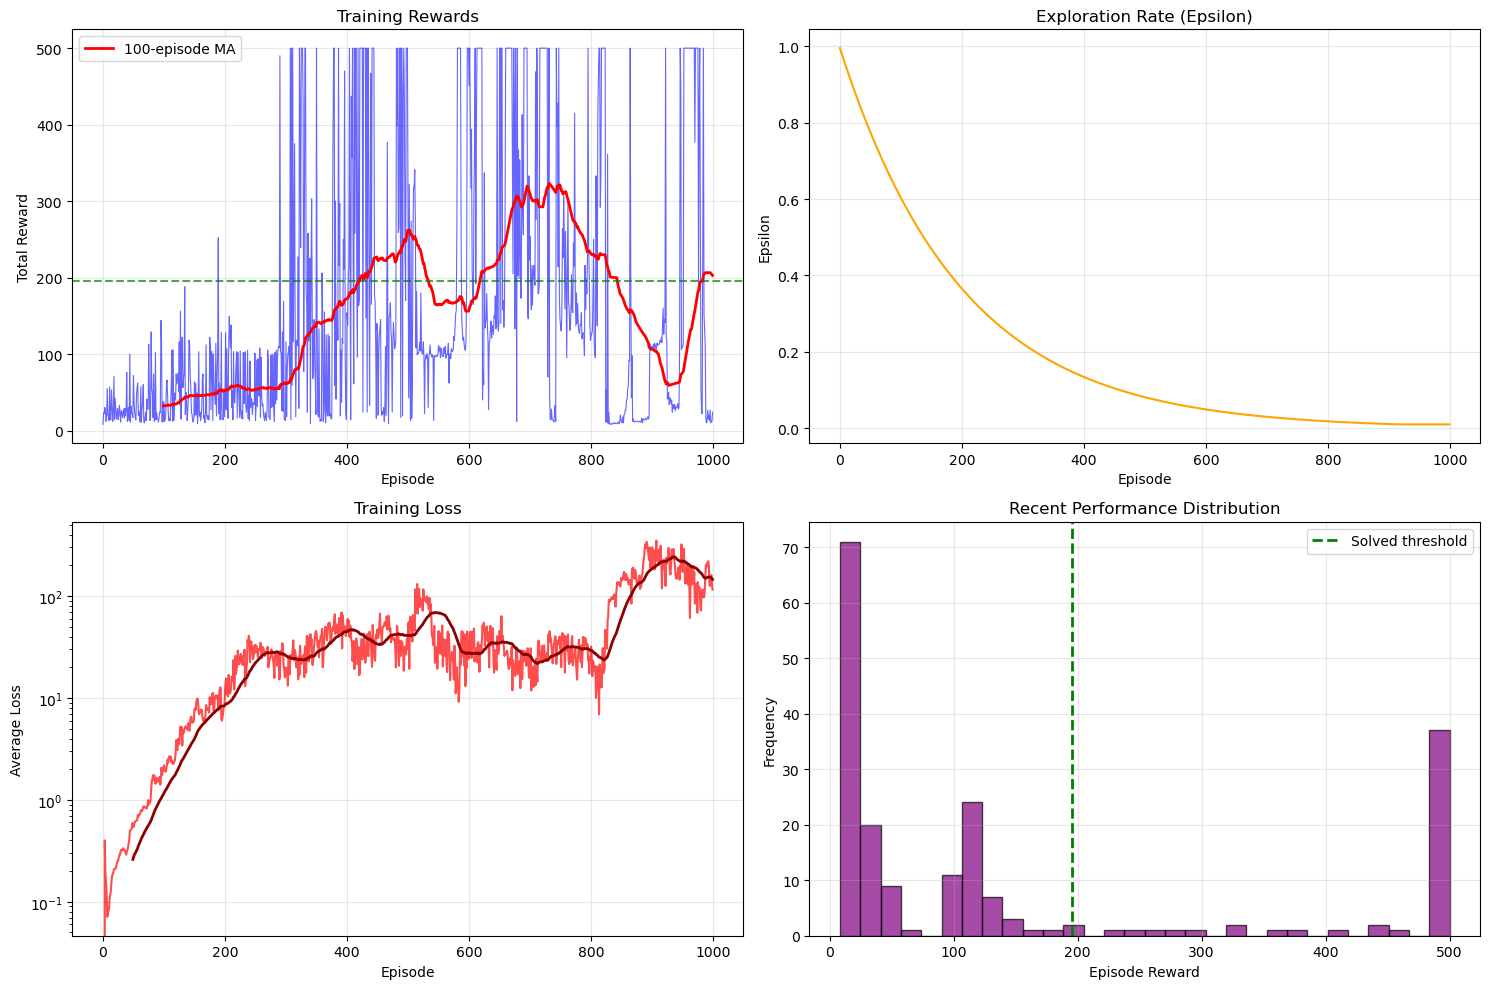


DQN Network Analysis:
Network parameters: 33922
Replay buffer size: 10000
Final epsilon: 0.0100

Sample Q-values for different states:
Balanced state      : Q=[233.327, 226.843] -> Action 0
Cart right, pole right: Q=[196.298, 190.819] -> Action 0
Cart left, pole left: Q=[267.923, 243.339] -> Action 0
Moving right        : Q=[235.276, 207.853] -> Action 0
Moving left         : Q=[154.099, 147.336] -> Action 0

Testing trained DQN agent...
Test Episode  1: Reward =  15, Steps = 15
Test Episode  2: Reward =  15, Steps = 15
Test Episode  3: Reward =  13, Steps = 13
Test Episode  4: Reward =  13, Steps = 13
Test Episode  5: Reward =  13, Steps = 13
Test Episode  6: Reward =  12, Steps = 12
Test Episode  7: Reward =  11, Steps = 11
Test Episode  8: Reward =  11, Steps = 11
Test Episode  9: Reward =  11, Steps = 11
Test Episode 10: Reward =  15, Steps = 15

Average test reward: 12.90
Success rate (≥195 steps): 0.0%
Model saved to cartpole_dqn_model.pth

TRAINING COMPLETED!
Final 100-episode 

In [44]:
if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # Train the DQN agent
    print("="*60)
    print("DEEP Q-NETWORK (DQN) TRAINING")
    print("="*60)
    
    trained_agent, training_rewards, training_epsilons, training_losses = train_dqn(episodes=1000)
    
    # Plot training progress
    plot_training_progress(training_rewards, training_epsilons, training_losses)
    
    # Analyze the trained network
    analyze_network(trained_agent)
    
    # Test the trained agent
    test_rewards = test_dqn(trained_agent, episodes=10, render=False)
    
    # Save the trained model
    trained_agent.save_model('cartpole_dqn_model.pth')
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED!")
    print("="*60)
    
    # Show final performance
    final_avg = np.mean(training_rewards[-100:])
    print(f"Final 100-episode average: {final_avg:.2f}")
    print(f"Environment solved: {'Yes' if final_avg >= 195 else 'No'}")
    
    # Example of loading and testing saved model
    # new_agent = DQNAgent()
    # new_agent.load_model('cartpole_dqn_model.pth')
    # test_dqn(new_agent, episodes=5, render=False)